In [ ]:
!pip install requests shapely matplotlib pillow

In [ ]:
import json
import requests
from datetime import datetime
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

### 1. Sentinel Hub OAuth credentials
CLIENT_ID = "d50d9409-cf9c-45d1-8626-7c63f70b21d2"
CLIENT_SECRET = "KAW9viUHJKFnb6CFXSatxlWTwvlFBxnW"

### 2. Çalışmak istediğin veri seti
# yangın analizi için Sentinel-2 yüzey yansıtımı (atmosfer düzeltilmiş)
COLLECTION_ID = "sentinel-2-l2a"

### 3. AOI (Area of Interest) = bbox [minLon, minLat, maxLon, maxLat]
# August Complex Fire, Northern California (Mendocino / Shasta-Trinity area)
BBOX = [-123.5, 39.5, -122.7, 40.1]

### 4. Tarih aralığı (UTC ISO8601)
# aktif yangın dönemi (yoğun duman ve sıcak noktalar)
START_TIME = "2020-08-25T00:00:00Z"
END_TIME   = "2020-08-28T23:59:59Z"

### 5. Bulut oranı filtresi (yüzde)
# not: duman da "bulut" gibi görünebilir ama yine de 40 üstüne çıkmaya gerek yok
MAX_CLOUD = 40

### 6. Çıktı görüntü boyutu (piksel)
IMG_WIDTH = 512
IMG_HEIGHT = 512


In [ ]:
# BLOK 2 — Access Token Al (OAuth2 Client Credentials Flow)

TOKEN_URL = "https://services.sentinel-hub.com/auth/realms/main/protocol/openid-connect/token"

data = {
    "grant_type": "client_credentials",
    "client_id": CLIENT_ID,
    "client_secret": CLIENT_SECRET,
}

token_resp = requests.post(TOKEN_URL, data=data)
token_resp.raise_for_status()  # hata varsa burada patlar

token_json = token_resp.json()
access_token = token_json["access_token"]

print(access_token[:80] + "...")  # güvenlik için sadece ilk kısmı gösteriyoruz


eyJhbGciOiJSUzI1NiIsInR5cCIgOiAiSldUIiwia2lkIiA6ICJ3dE9hV1o2aFJJeUowbGlsYXctcWd4...


In [ ]:
# BLOK 3 — Katalogdan uygun Sentinel-2 sahnelerini ara

SEARCH_URL = "https://services.sentinel-hub.com/api/v1/catalog/1.0.0/search"

# Sentinel Hub STAC aramasında tarih aralığı "from/to" yerine "from/to" birleşik string olarak veriliyor
datetime_interval = f"{START_TIME}/{END_TIME}"

search_payload = {
    "collections": [COLLECTION_ID],  # "sentinel-2-l2a"
    "bbox": BBOX,                    # [-123.5, 39.5, -122.7, 40.1] (California yangını için)
    "datetime": datetime_interval,   # "2020-08-25T00:00:00Z/2020-08-28T23:59:59Z"
    "limit": 10                      # ilk 10 sonucu çekelim
}

headers = {
    "Authorization": f"Bearer {access_token}",
    "Content-Type": "application/json",
}

search_resp = requests.post(SEARCH_URL, headers=headers, data=json.dumps(search_payload))
search_resp.raise_for_status()

search_json = search_resp.json()
features = search_json.get("features", [])

print(f"🔍 Toplam {len(features)} aday sahne bulundu.")

# yardımcı küçük fonksiyon: bulut oranını çek
def cloud_of(feat):
    return feat["properties"].get("eo:cloud_cover", 999)

# MAX_CLOUD filtresini uygula
filtered = [f for f in features if cloud_of(f) <= MAX_CLOUD]

# eğer hiçbiri MAX_CLOUD altı değilse fallback olarak en düşük bulutluyu seç
if not filtered and features:
    filtered = sorted(features, key=cloud_of)[:1]

if not filtered:
    raise RuntimeError("⚠️ Uygun Sentinel-2 L2A görüntüsü bulunamadı. "
                       "Tarih/bbox/bulut filtresini değiştirmen gerekebilir.")

# bulutuna göre sırala, en iyisini seç
chosen = sorted(filtered, key=lambda f: cloud_of(f))[0]

chosen_id = chosen["id"]
chosen_datetime = chosen["properties"]["datetime"]
chosen_cloud = chosen["properties"].get("eo:cloud_cover", None)
chosen_bbox = chosen["bbox"]

print("✅ Seçilen görüntü:")
print("  ID:", chosen_id)
print("  Tarih:", chosen_datetime)
print("  Bulut oranı:", chosen_cloud)
print("  Sahnenin kendi bbox'u:", chosen_bbox)


🔍 Toplam 7 aday sahne bulundu.
✅ Seçilen görüntü:
  ID: S2B_MSIL2A_20200827T184919_N0214_R113_T10SEJ_20200827T213744
  Tarih: 2020-08-27T19:03:43Z
  Bulut oranı: 0.15
  Sahnenin kendi bbox'u: [-123.00022131290406, 38.754045180862605, -121.71873148679857, 39.750251213708424]


In [ ]:
# BLOK 4 — Evalscript'ler (görüntüyü nasıl render edeceğiz?)

# 1) Doğal renk (true color): Kırmızı=B04, Yeşil=B03, Mavi=B02
TRUE_COLOR_EVALSCRIPT = r"""
//VERSION=3
function setup() {
  return {
    input: [{
      bands: ["B04", "B03", "B02"],
      units: "REFLECTANCE"
    }],
    output: {
      bands: 3,
      sampleType: "AUTO"
    }
  };
}

function evaluatePixel(sample) {
  return [sample.B04, sample.B03, sample.B02];
}
"""

# 2) Yangın vurgulu SWIR composite:
#   R = B12 (SWIR2)
#   G = B11 (SWIR1)
#   B = B04 (Red)
# SWIR bantları sıcak yüzeyleri ve yanan/kızgın alanları çok net parlatır.
FIRE_SWIR_EVALSCRIPT = r"""
//VERSION=3
function setup() {
  return {
    input: [{
      bands: ["B12", "B11", "B04"],
      units: "REFLECTANCE"
    }],
    output: {
      bands: 3,
      sampleType: "AUTO"
    }
  };
}

function evaluatePixel(sample) {
  // Biraz gain veriyoruz ki daha parlak çıksın.
  return [
    3.5 * sample.B12,  // Kırmızı kanal
    3.5 * sample.B11,  // Yeşil kanal
    3.5 * sample.B04   // Mavi kanal
  ];
}
"""

print("✅ Evalscript'ler yüklendi. Bir sonraki blokta hangisini kullanacağını seçeceğiz.")


✅ Evalscript'ler yüklendi. Bir sonraki blokta hangisini kullanacağını seçeceğiz.


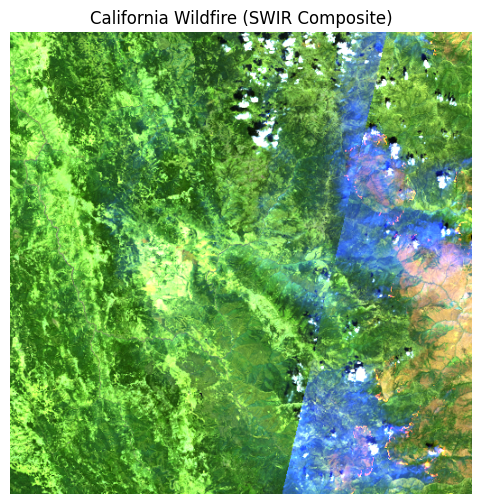

💾 Görüntü 'california_wildfire.png' olarak kaydedildi.


In [ ]:
# BLOK 5 — Sentinel Hub Process API ile görüntüyü indir ve göster

PROCESS_URL = "https://services.sentinel-hub.com/api/v1/process"

# Hangi script ile render edeceğiz?
EVALSCRIPT = FIRE_SWIR_EVALSCRIPT  # istersen TRUE_COLOR_EVALSCRIPT yapabilirsin

process_payload = {
    "input": {
        "bounds": {
            "bbox": BBOX,
            "properties": {
                # CRS84 = lon/lat (WGS84). Biz BBOX'u o formatta verdik.
                "crs": "http://www.opengis.net/def/crs/OGC/1.3/CRS84"
            }
        },
        "data": [
            {
                "type": COLLECTION_ID,   # "sentinel-2-l2a"
                "dataFilter": {
                    "timeRange": {
                        "from": START_TIME,
                        "to": END_TIME
                    },
                    "maxCloudCoverage": MAX_CLOUD,
                    "mosaickingOrder": "mostRecent"
                },
                "processing": {
                    "upsampling": "BILINEAR",
                    "downsampling": "BILINEAR"
                }
            }
        ]
    },
    "output": {
        "width": IMG_WIDTH,
        "height": IMG_HEIGHT,
        "responses": [
            {
                "identifier": "default",
                "format": {
                    "type": "image/png"
                }
            }
        ]
    },
    "evalscript": EVALSCRIPT
}

headers = {
    "Authorization": f"Bearer {access_token}",
    "Content-Type": "application/json",
    "Accept": "image/png"  # direkt PNG dönmesini istiyoruz
}

resp = requests.post(PROCESS_URL, headers=headers, data=json.dumps(process_payload))
resp.raise_for_status()

# Dönen PNG'yi Pillow ile aç
img = Image.open(BytesIO(resp.content))

# Görseli göster
plt.figure(figsize=(6,6))
plt.imshow(img)
plt.axis("off")
plt.title("California Wildfire (SWIR Composite)")
plt.show()

# İstersen diske kaydet
img.save("california_wildfire.png")
print("💾 Görüntü 'california_wildfire.png' olarak kaydedildi.")
